In [96]:
import torchvision.transforms
from torch.utils.data import DataLoader
import torch.utils.data.dataloader
from torch import nn
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torchsummary

Defining train function for training a model

In [97]:
def train(
        mdl,
        train_dataloader,
        valid_dataloader,
        n_epoch,
        opt,
        criterion,
        valid_step,
        save_path):
    min_valid_loss = float('inf')

    best_state = 0

    # save training and validation losses to draw them later
    trn_losses = []
    vld_losses = []

    train_loss = 0.0
    valid_loss = 0.0


    for e in range(0, n_epoch):
        mdl.train()
        train_loss = 0.0
        for _, (inp, out) in enumerate(train_dataloader):
            opt.zero_grad()
            pred = mdl(inp)
            loss = criterion(pred, out)
            loss.backward()
            opt.step()
            train_loss += loss.item()

        trn_losses.append(train_loss)

        # if it is not time to calculate validation, continue
        if e % valid_step != 0 and e != 0:
            vld_losses.append(valid_loss)
            continue

        mdl.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for i, (inp, out) in enumerate(valid_dataloader):
                pred = mdl(inp)
                ls = criterion(pred, out)
                valid_loss += ls.item()

        vld_losses.append(valid_loss)

        # if they are better weights save them (less loss = better weights)
        if valid_loss < min_valid_loss:
            best_state = mdl.state_dict()
            if save_path != '':
                p = save_path.format(
                    en=n_epoch,
                    vl=valid_loss,
                    tl=train_loss)
                torch.save(mdl, p)

        print('epoch: ' + str(e + 1))
        print('train loss: ' + str(train_loss / len(train_dataloader)))
        print('valid loss: ' + str(valid_loss / len(valid_dataloader)))
        print('\n')

    return trn_losses, vld_losses, best_state


In [98]:
tns = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
ds = torchvision.datasets.MNIST(root='data/dataset', train=True, download=True, transform=tns)

In [99]:
N_TRAIN = 10000
N_VALID = 1000
n_test = 2000
train_ds, valid_ds, test_ds, _ = \
    torch.utils.data.random_split(
        ds, [N_TRAIN, N_VALID, n_test, len(ds) - (N_TRAIN + N_VALID + n_test)])

train_dl = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(dataset=valid_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(dataset=test_ds, batch_size=512, shuffle=True)



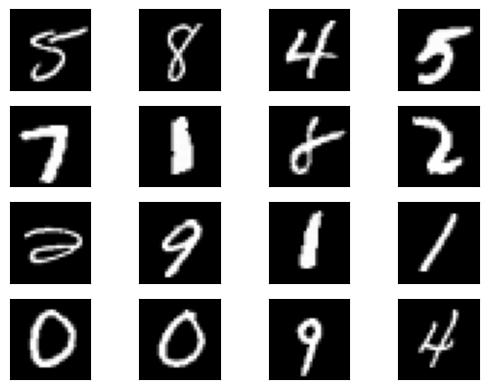

In [100]:
en = enumerate(train_dl)
k, (inps, outs) = next(en)
fig = plt.figure()

for i in range(16):
    plt.subplot(4, 4, i+1)
    im = inps[i][0]
    plt.imshow(im, cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [101]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),
    nn.Flatten(),
    nn.Linear(800, 10),
    nn.Sigmoid(),
    nn.Linear(10, 10),
    nn.LogSoftmax())

s = torchsummary.summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            160
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            4,640
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Flatten: 1-7                           --
├─Linear: 1-8                            8,010
├─Sigmoid: 1-9                           --
├─Linear: 1-10                           110
├─LogSoftmax: 1-11                       --
Total params: 12,920
Trainable params: 12,920
Non-trainable params: 0


In [102]:
trn_ls, vld_ls, bst_state = train(
    mdl=model,
    train_dataloader=train_dl,
    valid_dataloader=valid_dl,
    n_epoch=10,
    opt=torch.optim.Adam(params=model.parameters(), lr=0.01),
    criterion=nn.CrossEntropyLoss(),
    valid_step=1,
    save_path='')

epoch: 1
train loss: 0.7791858484474615
valid loss: 0.2635226435959339


epoch: 2
train loss: 0.20259245310109644
valid loss: 0.15523285628296435


epoch: 3
train loss: 0.12677570671652452
valid loss: 0.14643171691568568


epoch: 4
train loss: 0.10720558242854504
valid loss: 0.15573688346194103


epoch: 5
train loss: 0.09332191276426513
valid loss: 0.17457501462195069


epoch: 6
train loss: 0.07518513824570532
valid loss: 0.14452131498546805


epoch: 7
train loss: 0.06652176429401524
valid loss: 0.11625184341392014


epoch: 8
train loss: 0.07058456524263342
valid loss: 0.12720716938201804


epoch: 9
train loss: 0.06356541479167085
valid loss: 0.19372360785200726


epoch: 10
train loss: 0.06887415095794791
valid loss: 0.1439969940111041




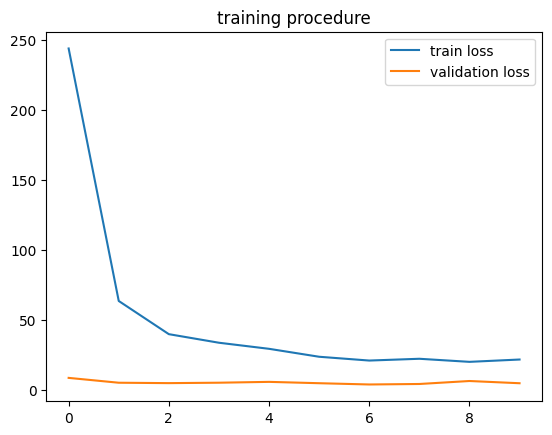

In [103]:
plt.plot(trn_ls)
plt.plot(vld_ls)
plt.legend(['train loss', 'validation loss'])
plt.title('training procedure')
plt.show()

Drawing some samples of the trained model
title of each sample is its predicted value
The title color indicated true or false predication(green or red)

D:\Projects\pytorch_triplet_mnist\venv\lib\site-packages\torch\nn\modules\module.py:1898: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
C:\Users\add\AppData\Local\Temp\ipykernel_5976\3288208646.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


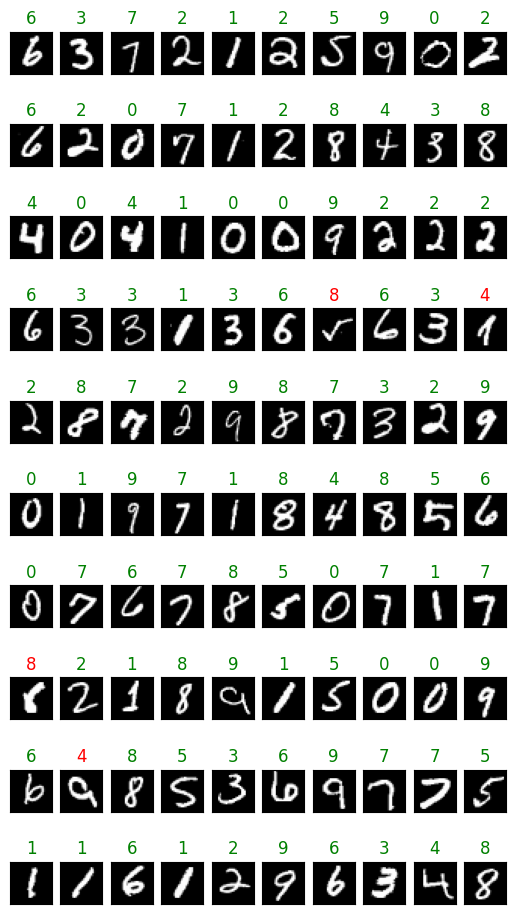

In [104]:
model.state_dict(bst_state)
model.eval()
ROWS = 10
COLS = 10
en = enumerate(test_dl)
_, (inps, outs) = next(en)
with torch.inference_mode():
    preds = model(inps)

fig = plt.figure()
#fig.text('Predicted samples')
for i in range(ROWS*COLS):
    plt.subplot(ROWS, COLS, i+1)
    im = inps[i][0]
    plt.imshow(im, cmap='gray')
    p = torch.argmax(preds[i]).item()
    o = outs[i].item()
    color = 'g'
    if p!=o:
        color = 'r'
    plt.title(str(p), color=color)
    plt.subplots_adjust(top=2)
    plt.xticks([])
    plt.yticks([])
fig.show()

Drawing confusion matrix

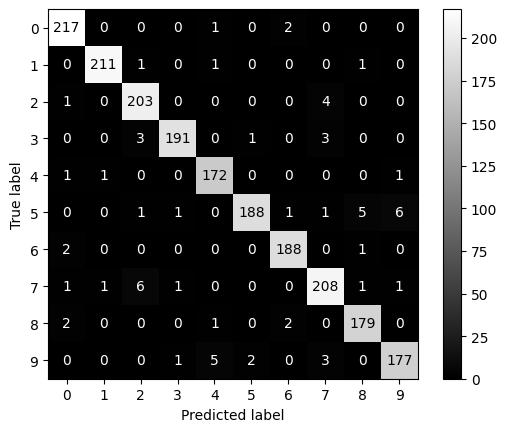

In [105]:
sum = 0.0

preds = []
labels = []
for idx, (inps, outs) in enumerate(test_dl):
    p = model(inps)
    p = torch.argmax(p, 1)
    preds.extend(p.tolist())
    labels.extend(outs.tolist())

cm = confusion_matrix(labels, preds)
ConfusionMatrixDisplay(cm).plot(cmap='gray')

calculating accuracy

In [106]:
for i in range(len(labels)):
    if labels[i] == preds[i]:
        sum+=1

print('accuracy: ' +
    str(sum/len(test_ds)))

accuracy: 0.967
